In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import warnings 
warnings.filterwarnings('ignore')


ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


Camera error for T_B,5 = 230K: 1.65 K
Camera error for T_B,5 = 270K: 0.41 K
Camera error for T_B,6 = 230K: 1.26 K
Camera error for T_B,6 = 270K: 0.42 K
Total uncertainty $\delta T_S$ surface skin temperature retrieval (SCA): 0.29 K


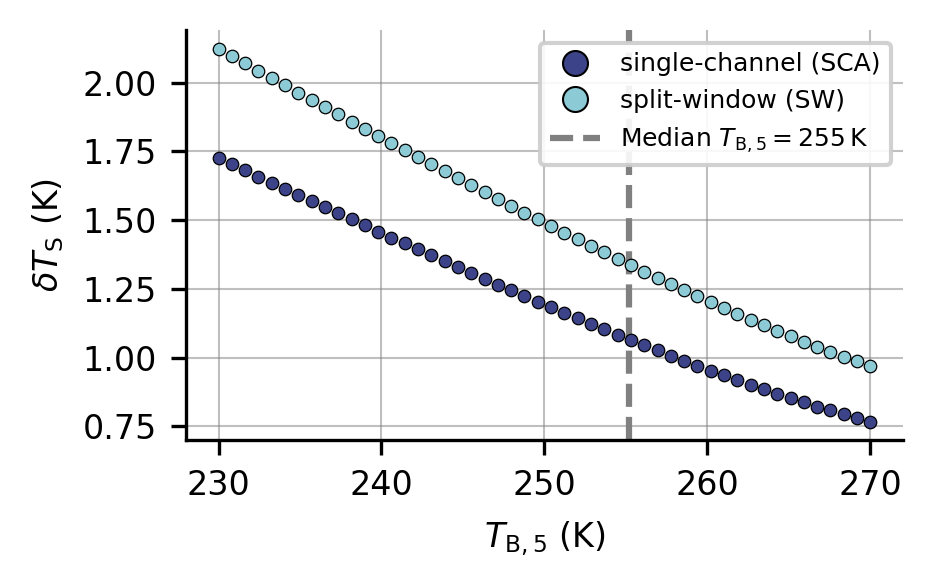

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean

ds_stds_disk = xr.open_dataset('../../data/correction_angle_temperature_dependence_stds_v1.nc')
ds_means_disk = xr.open_dataset('../../data/correction_angle_temperature_dependence_means_v1.nc')


# Constants
a_scs = 9.051  # K
b_scs = 0.967  # K^-1
e_atm_sca = 0.47  # K

b_sw = 0.95
a_sw = 11
c_sw = 2.09

NETD_B5 = 0.473  # K
NETD_B6 = 0.473  # K

a_b5 = 8.781  # K
b_b5 = -0.031  # K^-1

b_b6 = -0.022
a_b6 = 6.370

import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))
### make the scaling of the plot true in vscode

# Range of measured brightness temperatures (T_B,5)
T_B5 = np.linspace(230, 270, 50)  # from 230K to 270K
T_B6 = T_B5 * 0.947 + 14.584 ### from the fit performed later hihi

# Calculate the internal camera error for each T_B,5
delta_T_camera_5 = a_b5 + b_b5 * T_B5
delta_T_camera_6 = a_b6 + b_b6 * T_B6

print(f'Camera error for T_B,5 = 230K: {delta_T_camera_5[0]:.2f} K')
print(f'Camera error for T_B,5 = 270K: {delta_T_camera_5[-1]:.2f} K')

print(f'Camera error for T_B,6 = 230K: {delta_T_camera_6[0]:.2f} K')
print(f'Camera error for T_B,6 = 270K: {delta_T_camera_6[-1]:.2f} K')

# Calculate the uncertainty in T_B,5
delta_T_B5 = np.sqrt((NETD_B5)**2 + delta_T_camera_5**2)
delta_T_B6 = np.sqrt((NETD_B6)**2 + delta_T_camera_6**2)

# Calculate the total uncertainty for the single-channel algorithm (SCA)
delta_T_S_sca = np.sqrt(e_atm_sca**2 + (b_scs * delta_T_B5)**2)
delta_T_S_sw = np.sqrt(e_atm_sca**2 + (b_sw * delta_T_B5)**2 + (b_sw * delta_T_B6)**2)

delta_T_S_sca_avg = np.std(delta_T_S_sca)
#delta_T_S_sca_avg = np.sqrt(NETD_B5**2 * b_scs**2 + e_atm_sca**2 + 0.93**2)
print(f'Total uncertainty $\delta T_S$ surface skin temperature retrieval (SCA): {delta_T_S_sca_avg:.2f} K')



# import seaborn as sns  
# sns.set_style("whitegrid")

settings = json.load(open('../plot_settings.json'))
plt.rcParams.update(settings)



plt.rcParams.update(
    {
        'font.size': 8,
        'axes.labelsize': 8,
        'legend.fontsize': 6,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'axes.titlesize': 8,
    }
)

fig, ax = plt.subplots(figsize=(3.15, 2))

# Plotting

colors = cmocean.cm.ice

c1 = colors(.3)
c2 = colors(.8)

ax.scatter(T_B5, delta_T_S_sca, color=cmocean.cm.ice(.3), s=9, edgecolors='black', linewidth=0.3, label='single-channel (SCA)', zorder=2)
ax.scatter(T_B5, delta_T_S_sw, color=cmocean.cm.ice(.8), s=9, edgecolors='black', linewidth=0.3, label='split-window (SW)', zorder=2)
ax.set_xlabel('$T_\mathrm{B,5}$ (K)')
ax.set_ylabel('$\delta T_\mathrm{S}$ (K)')

handles = [plt.Line2D([0], [0], marker='o', color='w', label='single-channel (SCA)', markerfacecolor=c1, markersize=6, markeredgecolor='k', markeredgewidth=.5),
           plt.Line2D([0], [0], marker='o', color='w', label='split-window (SW)', markerfacecolor=c2, markersize=6, markeredgecolor='k', markeredgewidth=.5)]

#ax.legend(handles=handles, loc='upper left', frameon=True, fancybox=True, shadow=False, framealpha=0.9)

# Add median line
median_tb5 = np.median(ds_means_disk.BT_2D.isel(band=3).values + 273.15)
ax.axvline(median_tb5, color='gray', lw=1.5, ls='--', label='Median $T_\mathrm{B,5}=255\,$K', zorder=0)

handles += [plt.Line2D([0], [0], color='gray', lw=1.5, ls='--', label='Median $T_\mathrm{B,5}=255\,$K')]

# Add legend
ax.legend(handles=handles, loc='upper right', frameon=True, fancybox=True, shadow=False, framealpha=0.9)
#ax.axes.grid(False, )
ax.axes.grid(True, which='major', color='gray', linewidth=0.5, alpha=0.5, zorder=1)
ax.spines[['top', 'right']].set_visible(False)
# Adjust layout



plt.tight_layout()

# Save the plot

plt.savefig('../../plots/publish/figure02.png', dpi=300, bbox_inches='tight')